RDKit WARNING: [14:40:07] Enabling RDKit 2019.09.3 jupyter extensions


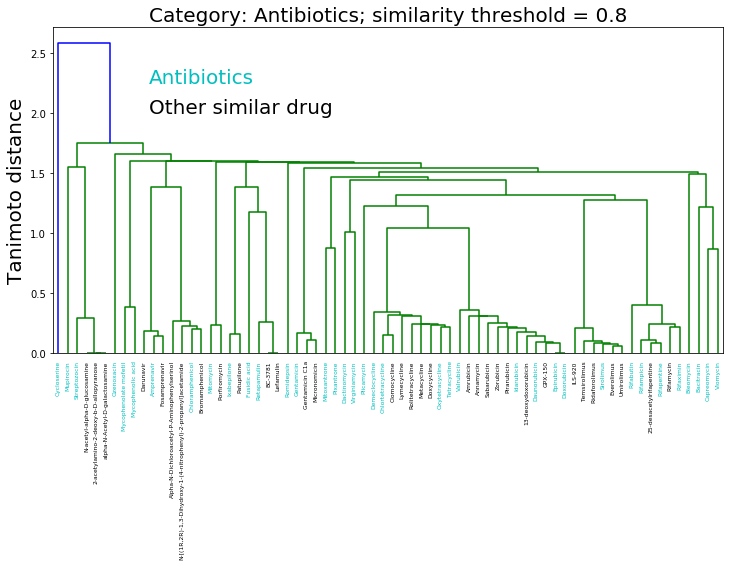

Approved Antibiotics:

['Cycloserine' 'Bleomycin' 'Mitomycin' 'Capreomycin' 'Valrubicin'
 'Mupirocin' 'Streptozocin' 'Epirubicin' 'Chloramphenicol'
 'Oxytetracycline' 'Rifabutin' 'Demeclocycline' 'Bacitracin'
 'Mycophenolate mofetil' 'Daunorubicin' 'Amprenavir' 'Tetracycline'
 'Gentamicin' 'Sirolimus' 'Dactinomycin' 'Neomycin' 'Doxorubicin'
 'Mycophenolic acid' 'Rifampicin' 'Idarubicin' 'Rifapentine'
 'Mitoxantrone' 'Rifaximin' 'Retapamulin' 'Fusidic acid' 'Ixabepilone'
 'Romidepsin' 'Pixantrone' 'Plicamycin' 'Viomycin' 'Chlortetracycline'
 'Virginiamycin' 'Ozenoxacin' 'Tyrothricin']

Other similar drugs:

Porfiromycin: investigational, Antibiotics, Antineoplastic; Antineoplastic Agents; Azirines; Heterocyclic Compounds, Fused-Ring; Indolequinones; Indoles; Mitomycins; Quinones

2-acetylamino-2-deoxy-b-D-allopyranose: experimental, Unknown

alpha-N-Acetyl-D-galactosamine: experimental; investigational, Unknown

N-acetyl-alpha-D-glucosamine: experimental, Unknown

13-deoxydoxorubicin: i


Annamycin: investigational, Anthracyclines; Antibiotics, Antineoplastic; Antineoplastic Agents; Carbohydrates; Glycosides; Naphthacenes; P-glycoprotein inhibitors

BC-3781: investigational, Acetates; Acids, Acyclic; Fatty Acids; Fatty Acids, Volatile; Lipids; Sulfhydryl Compounds; Sulfur Compounds; Terpenes

Lefamulin: approved; investigational, Acetates; Cytochrome P-450 CYP3A Substrates; Cytochrome P-450 CYP3A4 Substrates; Cytochrome P-450 CYP3A4 Substrates (strength unknown); Cytochrome P-450 Substrates; P-glycoprotein substrates; QTc Prolonging Agents; Sulfur Compounds

Patupilone: experimental; investigational, Anti-Bacterial Agents; Antimitotic Agents; Antineoplastic Agents; Cytochrome P-450 CYP3A Inhibitors; Cytochrome P-450 CYP3A4 Inhibitors; Cytochrome P-450 CYP3A4 Inhibitors (strength unknown); Cytochrome P-450 Enzyme Inhibitors; Lactones; Macrolides; Mitosis Modulators; Polyketides; Tubulin Modulators

Clomocycline: experimental, Agents that produce neuromuscular block (ind

In [1]:
# Find new drugs by category - Antibiotics

import pandas as pd
import sys
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from scipy.spatial.distance import squareform as sf
import scipy.cluster.hierarchy as hier
import matplotlib.pyplot as plt

category = 'Antibiotics'
similarity_threshold = 0.8
morgan_radius = 2

filepath = '/Users/OfficeDeskTop/DI Capstone/'
structdata = pd.read_csv(filepath + 'structure links clean.csv')
#print(pd.structdata['Name'].isin('Bivalirudin'))
fulldata = pd.read_csv(filepath + 'full database.csv')
#print(len(fulldata))

# Define incol function - returns boolean

def incol(value, dataframe, column):
    
    for x in dataframe[column]:
        if x == value:
            return True
    return False

# Define simchems function - returns list of similar chemicals

def simchems(target_drug, dataframe, similarity_threshold, morgan_radius):
    
    # Find target_drug in dataframe
    
    size = len(dataframe)
    
    i = 0
    while dataframe.at[i, 'Name'] != target_drug:
        if i == size - 1:
            sys.exit('Reading ERROR: "' + target_drug + '" not found in dataset.')
        else:
            i += 1
            
    smiles_target = dataframe.at[i, 'SMILES']
    if smiles_target is np.nan:
        sys.exit('Completeness ERROR: ' + target_drug + ' SMILES unavailable.')
        
    names_array = []
    
    # Find drugs similar to target_drug

    ms_target = Chem.MolFromSmiles(smiles_target)
    fps_target = AllChem.GetMorganFingerprint(ms_target, morgan_radius)
    
    for i in range(size):
        name_i = dataframe.at[i, 'Name']
        
        if name_i != target_drug:        
            smiles_i = dataframe.at[i, 'SMILES']
            
            if smiles_i is not np.nan:
                ms_i = Chem.MolFromSmiles(smiles_i)
                
                if ms_i is not None:
                    fps_i = AllChem.GetMorganFingerprint(ms_i, morgan_radius)
                    T_target_i = DataStructs.DiceSimilarity(fps_target, fps_i)
                    
                    if T_target_i > similarity_threshold:
                        names_array = np.append(names_array, name_i)
                        
    return names_array

# Define cdistmatrix function - returns condensed distance matrix

def cdistmatrix(names_array, dataframe, morgan_radius):
    
    # Get SMILES array
    
    smiles_array = []
    for x in names_array:
        i = 0
        while x != dataframe.at[i, 'Name']:
            i += 1
        
        smiles_array = np.append(smiles_array, dataframe.at[i, 'SMILES'])
        
    # Compute redundant distmatrix
        
    size = len(smiles_array)                
    rdist_matrix = np.zeros((size, size))
    
    for i in range(size):
        ms_i = Chem.MolFromSmiles(smiles_array[i])
        fps_i = AllChem.GetMorganFingerprint(ms_i, morgan_radius)
    
        for j in range(i + 1, size):
            ms_j = Chem.MolFromSmiles(smiles_array[j])
            fps_j = AllChem.GetMorganFingerprint(ms_j, morgan_radius)
            T_ij = DataStructs.DiceSimilarity(fps_i, fps_j)
            rdist_matrix[i, j] = -np.log(T_ij)/np.log(2)
            rdist_matrix[j, i] = -np.log(T_ij)/np.log(2)
            
    return sf(rdist_matrix)

# Define groupat function - returns list of groups for target_drug

def groupat(target_drug, dataframe):
    for i in dataframe.index[:]:
        if dataframe.at[i, 'name'] == target_drug:
            if dataframe.at[i, 'groups'] is not np.nan:
                return dataframe.at[i, 'groups']
            else:
                return 'Unknown'
        
# Define catat function - returns list of categories for target_drug
def catat(target_drug, dataframe):
    for i in dataframe.index[:]:
        if dataframe.at[i, 'name'] == target_drug:
            if dataframe.at[i, 'categories'] is not np.nan:
                return dataframe.at[i, 'categories']
            else:
                return 'Unknown'
            
# Find approved drugs in category in fulldata

approved = []
for i in fulldata.index[:]:
    gr_i = fulldata.at[i, 'groups']
    cat_i = fulldata.at[i, 'categories']
    if gr_i is not np.nan and 'approved' in gr_i and cat_i is not np.nan and category in cat_i:
        approved = np.append(approved, fulldata.at[i, 'name'])
#print(approved)
#print(len(approved))

# Find similar drugs to those in approved

sim = []  
for x in approved:
    if incol(x, structdata, 'Name'):
        sim = np.append(sim, x)
        sim_x = simchems(x, structdata, similarity_threshold, morgan_radius)
    
        for y in sim_x:
            if y not in sim:
                sim = np.append(sim, y)

#print(len(sim))
#print(sim)
            
# Remove duplicates from sim
            
i = 0
while i < len(sim) - 1:
    if sim[i] in sim[i + 1:len(sim)]:
        if i == 0:
            sim = sim[1:len(sim)]
        elif i == len(sim) - 1:
            sim = sim[0:len(sim) - 1]
        else:
            sim = np.append(sim[0:i], sim[i + 1:len(sim)])
    else:
        i += 1
"""    
for i in range(len(sim) - 1):
    print(sim[i] in sim[i + 1:len(sim)])
"""
# Compute distance matrix from sim

dist_matrix = cdistmatrix(sim, structdata, morgan_radius)

# Compute linkage matrix

link_matrix = hier.linkage(dist_matrix)

# Compute and plot dendrogram

plt.figure(figsize = [12, 6])
dendrogram = hier.dendrogram(link_matrix, labels = sim)
plt.title('Category: ' + category + '; similarity threshold = ' + 
          str(similarity_threshold), fontsize = 20)
plt.ylabel('Tanimoto distance', fontsize = 20)
plt.text(100, 2.25, category, color = 'c', fontsize = 20)
plt.text(100, 2, 'Other similar drug', color = 'k', fontsize = 20)

label_colors = {}
others = []
for x in sim:
    if x in approved:
        label_colors[x] = 'c'
    else:
        label_colors[x] = 'k'
        others = np.append(others, x)

ax = plt.gca()
labels = ax.get_xmajorticklabels()
for lbl in labels:
    lbl.set_color(label_colors[lbl.get_text()])
    
plt.show()

print('Approved ' + category + ':' + '\n')
print(approved)
print('\n' + 'Other similar drugs:')
for x in others:
    print('\n' + x + ': ' + groupat(x, fulldata) + ', ' + catat(x, fulldata))